In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-dataset/microsoft.csv
/kaggle/input/aapl-model/pytorch/default/1/stock_transformer_apple.pth
/kaggle/input/stock-data/amazon.csv
/kaggle/input/apple-data/apple.csv
/kaggle/input/apple-preprocess/scikitlearn/default/1/scaler_apple.joblib


In [153]:
from sklearn.preprocessing import StandardScaler

In [154]:
data = pd.read_csv("/kaggle/input/apple-data/apple.csv")

data.head()

,date,Close,High,Low,Open,Volume,normalized
0,2019-01-02,37.667191,37.889017,36.787049,36.944473,148158800,0.408963
1,2019-01-03,33.915249,34.757226,33.869929,34.342199,365248800,0.979500
2,2019-01-04,35.363071,35.432244,34.299271,34.473390,234428400,0.501658
3,2019-01-07,35.284363,35.499034,34.800166,35.468025,219111200,0.487303
4,2019-01-08,35.956997,36.212216,35.425097,35.673157,164101200,0.422461


In [155]:
features = data[['normalized', 'Open', 'Close', 'High', 'Low', 'Volume']].values
target = data['Close'].values

In [156]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

In [157]:
# scaler_path = "/kaggle/input/apple-preprocess/scikitlearn/default/1/scaler_apple.joblib"

# scaler = joblib.load(scaler_path)
# features = scaler.transform(features)


In [158]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

sequence_length = 10
X, y = [], []
for i in range(len(features) - sequence_length):
    X.append(features[i:i + sequence_length])
    y.append(target[i + sequence_length])

X = np.array(X)
y = np.array(y)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_size = int(0.98 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

train_dataset = StockDataset(X_train, y_train)
val_dataset = StockDataset(X_val, y_val)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [159]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_length, d_model)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x
        

In [160]:
class StockTransformer(nn.Module):
    def __init__(self, input_dim=6, d_model=252, nhead=12, num_layers=4, dim_feedforward=512):
        super(StockTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_length=10)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


    

In [161]:
# Save the scaler
# stock = "microsoft"
# scaler_path = f'/kaggle/working/scaler_{stock}.joblib'
# joblib.dump(scaler, scaler_path)
# print(f"Saved scaler to {scaler_path}")

In [162]:
# class TinyModel(nn.Module):

#     def__init__(self):
#     super(TinyModel, self).__init__()

#     self.lstm1 = nn.LSTM(10, 128)
#     self.batchnorm1 = nn.BatchNorm1d(6)
#     self.lstm2 = nn.LSTM(10, )
    

In [163]:
model = StockTransformer(input_dim=6, d_model=252 , nhead=12, num_layers=2, dim_feedforward=512)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs=90
patience = 0
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)  # Calls the forward method
        loss = criterion(output.squeeze(), y.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)  # Forward pass
            loss = criterion(output.squeeze(), y.squeeze())
            val_loss += loss.item()
    val_loss /= len(val_dataloader)  # Average validation loss per batch

    # Print training and validation losses
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_model_state = model.state_dict()
    #     patience_counter = 0

#         # Save the model state dictionary
#         model_path = f'/kaggle/working/stock_transformer_{stock}.pth'
#         torch.save(best_model_state, model_path)
#         print(f"Saved best model to {model_path}")

        
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print(f'Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}')
#             break

# # Load the best model (optional, already loaded during early stopping)
# if best_model_state is not None:
#     model.load_state_dict(best_model_state)

Epoch 1, Train Loss: 17374.5925, Val Loss: 44439.5352
Epoch 2, Train Loss: 13716.2180, Val Loss: 37590.9316
Epoch 3, Train Loss: 10369.4520, Val Loss: 30925.5889
Epoch 4, Train Loss: 7579.6737, Val Loss: 24919.8945
Epoch 5, Train Loss: 5606.2774, Val Loss: 19821.8525
Epoch 6, Train Loss: 4239.8415, Val Loss: 15663.0776
Epoch 7, Train Loss: 3524.8533, Val Loss: 13030.6924
Epoch 8, Train Loss: 2795.2245, Val Loss: 10907.8975
Epoch 9, Train Loss: 2348.7594, Val Loss: 8366.0063
Epoch 10, Train Loss: 1842.8566, Val Loss: 6749.8789
Epoch 11, Train Loss: 2123.7854, Val Loss: 5837.1108
Epoch 12, Train Loss: 1801.8604, Val Loss: 5181.4263
Epoch 13, Train Loss: 1617.2677, Val Loss: 4348.2422
Epoch 14, Train Loss: 1782.2197, Val Loss: 3406.5122
Epoch 15, Train Loss: 1881.8879, Val Loss: 3121.7949
Epoch 16, Train Loss: 1768.8913, Val Loss: 2689.9127
Epoch 17, Train Loss: 1649.8859, Val Loss: 3106.7606
Epoch 18, Train Loss: 1532.6331, Val Loss: 3510.2987
Epoch 19, Train Loss: 1121.0164, Val Loss: 3

In [164]:
model.eval()
with torch.no_grad():
    last_sequence = val_dataset[0][0].unsqueeze(0).to(device)
    prediction = model(last_sequence)  # Calls the forward method
    print(f'Predicted next closing price: {prediction.item():.2f}')
    

Predicted next closing price: 241.69


In [165]:
import matplotlib.pyplot as plt

In [166]:
predictions

array([233.92204, 234.62665, 232.91872, 231.38893, 228.86932, 225.49883,
       225.16609, 225.57245, 229.58551, 234.4806 , 234.25806, 234.54291,
       234.39404, 231.29759, 233.1771 , 233.26219, 233.06467, 232.36966,
       230.11234, 233.25879, 234.71841, 235.28728, 235.35272, 235.32008,
       235.29099, 235.27971, 235.34772, 235.36539, 235.37856, 234.98483,
       234.53694], dtype=float32)

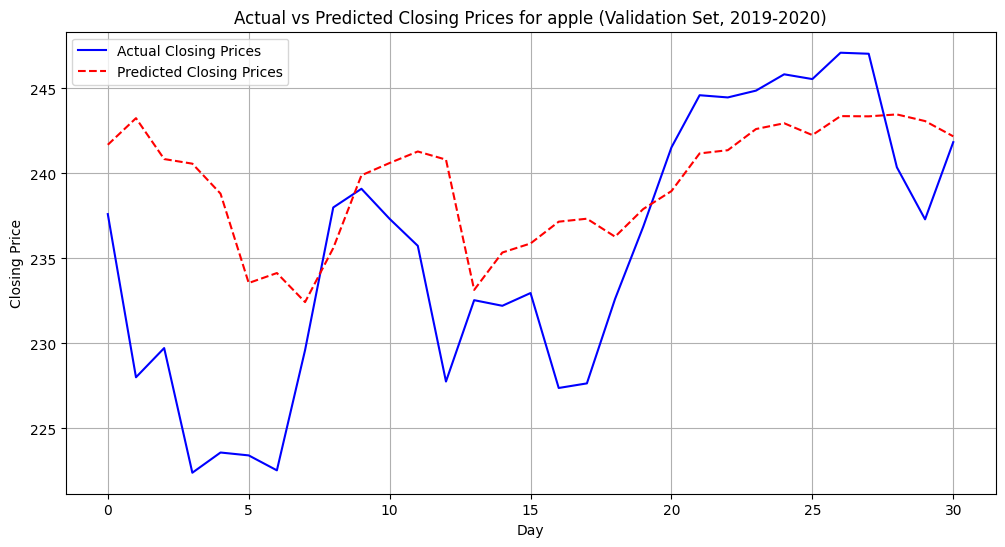

In [168]:
model.eval()  # Set model to evaluation mode
val_loss = 0
predictions = []
actuals = []
with torch.no_grad():  # Disable gradient computation for validation
    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        # print(output, ) # Forward pass
        predictions.extend(output.squeeze().cpu().numpy())
        actuals.extend(y.squeeze().cpu().numpy())
        loss = criterion(output.squeeze(), y.squeeze())
        val_loss += loss.item()
val_loss /= len(val_dataloader)





predictions = np.array(predictions)
actuals = np.array(actuals)

# Step 4: Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Closing Prices', color='blue')
plt.plot(predictions, label='Predicted Closing Prices', color='red', linestyle='--')
plt.title(f'Actual vs Predicted Closing Prices for {"apple"} (Validation Set, 2019-2020)')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()
